# Training GAT AE

This notebook shows how to train the anomaly detection model with GAT instead of GCN.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import optuna

from models import GATSpatioTemporalAutoencoder
from parameters import GATSTAEParameters, TrainingParameters
from datautils import get_morning_data
from training import save_model, load_model, train_gatstae, compute_anomaly_threshold, test_model, threshold_anomalies, fill_result_df
import torch.nn as nn
from tqdm import tqdm

import random
import os

/home/courseac/miniconda3/envs/transimputer-prognostics/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mse_weights = [1,4,1] # weights for loss function (occupancy, speed, volume)

In [3]:
training_params = TrainingParameters(
    learning_rate=1e-4,
    batch_size=1,
    timesteps=20,
    n_epochs=3
)

In [4]:
training_data = get_morning_data(1, timesteps=training_params.timesteps) # train on day 1

In [5]:
hyperparams = GATSTAEParameters(
    num_features=training_data[0][0].num_features,
    latent_dim=32,
    gcn_hidden_dim=64,
    lstm_hidden_dim=64,
    lstm_num_layers=2,
    dropout=0.2,
    gat_heads=1
)

In [6]:
ae = GATSpatioTemporalAutoencoder(hyperparams)

In [7]:
ae(training_data[0]).shape

torch.Size([196, 3])

In [8]:
ae, losses = train_gatstae(staeparams=hyperparams, trainingparams=training_params, training_data=training_data, mse_weights=mse_weights, verbose=True)

 33%|███▎      | 1/3 [01:58<03:57, 118.61s/it]

Epoch number 0 last 100 loss 0.03155317550525069


 67%|██████▋   | 2/3 [04:08<02:05, 125.17s/it]

Epoch number 1 last 100 loss 0.0174352866737172


100%|██████████| 3/3 [06:15<00:00, 125.10s/it]

Epoch number 2 last 100 loss 0.01574695359682664


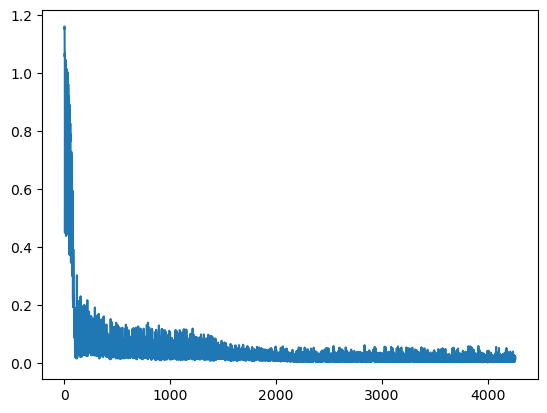

In [9]:
plt.plot(losses)

In [10]:
thresh = compute_anomaly_threshold(training_data, ae, mse_weights, 'max')

100%|██████████| 1421/1421 [00:55<00:00, 25.81it/s]


In [11]:
test_data = get_morning_data(4, timesteps=training_params.timesteps) # test on day 4, with crashes

In [12]:
test_errors, test_recons_speeds, test_true_speeds = test_model(test_data, mse_weights, ae)

In [13]:
np.mean(test_errors)

0.028532684

In [14]:
anomalies = threshold_anomalies(thresh, test_errors)

In [15]:
df = fill_result_df(anomalies, test_true_speeds, test_recons_speeds, training_params.timesteps)

In [16]:
df.to_csv('./saved_results/day4_results_gatw4.csv')

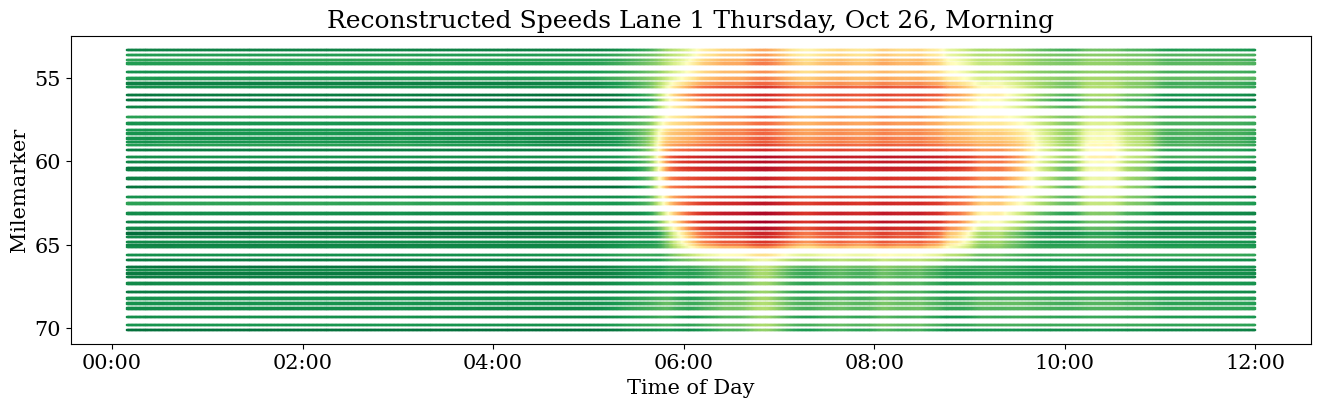

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data = pd.read_csv('./saved_results/day4_results_gatw4.csv', index_col=0)
data['Time Index'] = pd.to_datetime(data['Time Index'] * 30, unit='s')
plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("Reconstructed Speeds Lane 1 Thursday, Oct 26, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()

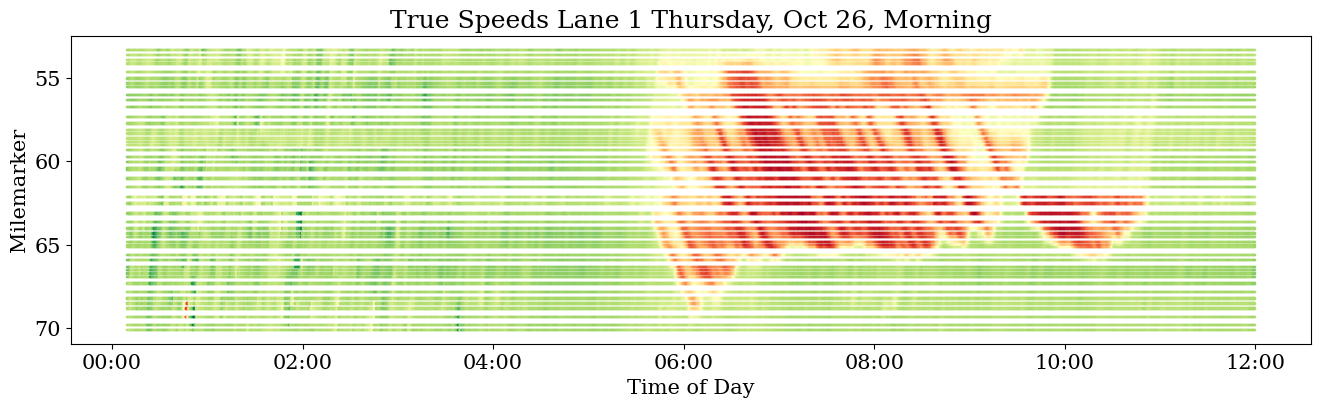

In [18]:
from matplotlib.ticker import MultipleLocator

plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Speed'].values,marker='s',s=1, cmap='RdYlGn')
plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_locator(MultipleLocator(0.01))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Set x-axis limits
start_time = pd.to_datetime('1970-01-01 09:30:00')
end_time = pd.to_datetime('1970-01-01 09:50:00')
# plt.xlim(start_time, end_time)
# plt.ylim()

plt.title("True Speeds Lane 1 Thursday, Oct 26, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()

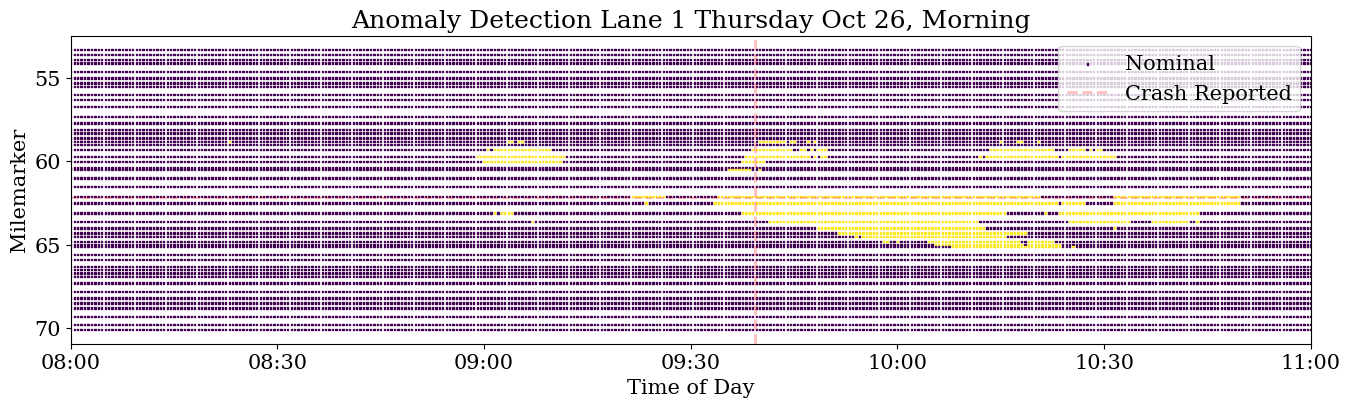

In [19]:
plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Anomaly'].values,marker='s',s=1, cmap='viridis', label='Nominal')
plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# Set x-axis limits
start_time = pd.to_datetime('1970-01-01 08:00:00')
end_time = pd.to_datetime('1970-01-01 11:00:00')
plt.xlim(start_time, end_time)

# Add vertical line at '1970-01-01 09:39:22'
vline_time = pd.to_datetime('1970-01-01 09:39:22')
plt.axvline(x=vline_time, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.25)
plt.axhline(y=62.2, color='red', linestyle='--', alpha=0.25)
# plt.ylim(60,65)
plt.legend(loc='upper right')
plt.title("Anomaly Detection Lane 1 Thursday Oct 26, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()